# Resampling Test

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch
import numpy as np
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt

from common.pinn_base import BasePINN, PINNConfig
from common.trainer import PINNTrainer, TrainerConfig
from common.visualizer import PINNVisualizer

In [2]:
class Heat3DPDE:
    """3D nonlinear heat equation from section 4.1"""
    
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def exact_solution(self, x: torch.Tensor) -> torch.Tensor:
        """u(x,y,z,t) = 2 + sin(5πt + πxyz)"""
        return 2 + torch.sin(5*np.pi*x[..., 3:4] + np.pi*x[..., 0:1]*x[..., 1:2]*x[..., 2:3])
        
    def source_term(self, x: torch.Tensor) -> torch.Tensor:
        """Compute Q(x,y,z,t) source term"""
        xyz = x[..., 0:1]*x[..., 1:2]*x[..., 2:3]
        t = x[..., 3:4]
        
        term1 = 5*np.pi*torch.cos(5*np.pi*t + np.pi*xyz)
        
        term2 = np.pi**2 * (x[..., 0:1]**2 * x[..., 1:2]**2 + 
                           x[..., 0:1]**2 * x[..., 2:3]**2 + 
                           x[..., 1:2]**2 * x[..., 2:3]**2)
        
        term3 = torch.cos(10*np.pi*t + 2*np.pi*xyz) - 2*torch.sin(5*np.pi*t + np.pi*xyz)
        
        return term1 - term2*term3
        
    def pde_operator(self, x: torch.Tensor, model: BasePINN) -> torch.Tensor:
        """Implements the PDE: u_t - ∇·(u∇u) = Q"""
        # Enable gradient computation
        x.requires_grad_(True)
        
        # Get model prediction
        u = model(x)
        
        # Compute derivatives
        du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_t = du_dx[..., 3:4]
        
        # Compute second derivatives for Laplacian
        u_x = du_dx[..., 0:1]
        u_y = du_dx[..., 1:2]
        u_z = du_dx[..., 2:3]
        
        # Compute diffusion term ∇·(u∇u)
        d2u_dx2 = torch.autograd.grad(u * u_x, x, torch.ones_like(u_x), create_graph=True)[0][..., 0:1]
        d2u_dy2 = torch.autograd.grad(u * u_y, x, torch.ones_like(u_y), create_graph=True)[0][..., 1:2]
        d2u_dz2 = torch.autograd.grad(u * u_z, x, torch.ones_like(u_z), create_graph=True)[0][..., 2:3]
        
        diffusion = d2u_dx2 + d2u_dy2 + d2u_dz2
        
        # Return residual
        return u_t - diffusion - self.source_term(x)

In [3]:
def run_experiment(num_residual_points: int, 
                  resampling_ratio: float,
                  device: torch.device) -> Dict[str, float]:
    """Run a single experiment with given parameters"""
    
    # Problem setup
    pde = Heat3DPDE()
    
    # Generate training points
    x_initial = torch.rand(100, 4, device=device)  # N_i = 100
    x_initial[:, 3] = 0  # Set t=0 for initial condition
    
    x_boundary = torch.rand(300, 4, device=device)  # N_b = 300
    # Set boundary points at x,y,z = 0,1
    x_boundary[:100, 0] = torch.randint(0, 2, (100,), device=device)
    x_boundary[100:200, 1] = torch.randint(0, 2, (100,), device=device)
    x_boundary[200:, 2] = torch.randint(0, 2, (100,), device=device)
    
    x_residual = torch.rand(num_residual_points, 4, device=device)
    
    # Get conditions from exact solution
    initial_condition = pde.exact_solution(x_initial)
    boundary_condition = pde.exact_solution(x_boundary)
    
    # Create test points
    x_test = torch.rand(10000, 4, device=device)
    y_test = pde.exact_solution(x_test)
    
    # Model configuration
    pinn_config = PINNConfig(
        hidden_layers=6,
        neurons_per_layer=50,
        activation=torch.nn.Tanh()
    )
    
    trainer_config = TrainerConfig(
        resampling_enabled=True if resampling_ratio > 0 else False,
        resampling_ratio=resampling_ratio,
        resampling_interval=200,
        resampling_termination=4000,
        adam_iterations=5000
    )
    
    # Create and train model
    model = BasePINN(input_dim=4, output_dim=1, config=pinn_config).to(device)
    trainer = PINNTrainer(model, trainer_config)
    
    # Training domain bounds for resampling
    domain_bounds = torch.tensor([[0, 1], [0, 1], [0, 1], [0, 1]], device=device)
    
    # Train model
    history = trainer.train(
        x_initial, initial_condition,
        x_boundary, boundary_condition,
        x_residual, domain_bounds, 
        lambda x: pde.pde_operator(x, model),
        x_test, y_test
    )
    
    return history

In [4]:
def run_all_experiments() -> None:
    """Run all experiments and create plots"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Experiment parameters
    # residual_points = [50, 100, 500, 1000, 2000]
    residual_points = [10, 20, 30, 40, 50]
    resampling_ratios = [0.0, 0.3, 0.6, 0.9]  # 0.0 = standard PINN
    num_repeats = 5
    
    # Store results
    results = {eta: [] for eta in resampling_ratios}
    
    # Run experiments
    for n_points in residual_points:
        print(f"\nRunning experiments with {n_points} residual points")
        
        for eta in resampling_ratios:
            print(f"  Resampling ratio η = {eta}")
            
            errors = []
            for i in range(num_repeats):
                print(f"    Repeat {i+1}/{num_repeats}")
                history = run_experiment(n_points, eta, device)
                errors.append(history['l2_relative'][-1])
                
            mean_error = np.mean(errors)
            results[eta].append(mean_error)
            
    # Create visualization
    visualizer = PINNVisualizer()
    plt.figure(figsize=(10, 6))
    
    for eta, errors in results.items():
        if eta == 0.0:
            label = 'Standard PINN'
        else:
            label = f'η = {eta}'
        plt.plot(residual_points, errors, 'o-', label=label)
    
    plt.xlabel('Num. of Residual points')
    plt.ylabel('Relative L2 error')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.title('Effect of Resampling Strategy on 3D Heat Equation')
    plt.savefig('heat_3d_resampling.png')
    plt.show()

Using device: cuda

Running experiments with 10 residual points
  Resampling ratio η = 0.0
    Repeat 1/5
Starting Adam optimization phase...


c:\Users\mated\anaconda3\envs\torch_win39\lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step 0: Loss = 139.644119
Step 100: Loss = 5.227610
Step 200: Loss = 3.289800
Step 300: Loss = 2.725805
Step 400: Loss = 2.332481
Step 500: Loss = 1.925111
Step 600: Loss = 1.629492
Step 700: Loss = 1.918779
Step 800: Loss = 0.907755
Step 900: Loss = 0.799729
Step 1000: Loss = 0.763501
Step 1100: Loss = 0.734997
Step 1200: Loss = 0.710823
Step 1300: Loss = 0.690092
Step 1400: Loss = 0.672155
Step 1500: Loss = 0.656491
Step 1600: Loss = 0.642682
Step 1700: Loss = 0.630534
Step 1800: Loss = 0.619453
Step 1900: Loss = 0.609539
Step 2000: Loss = 0.600585
Step 2100: Loss = 0.592447
Step 2200: Loss = 0.619903
Step 2300: Loss = 0.578591
Step 2400: Loss = 0.572619
Step 2500: Loss = 0.567208
Step 2600: Loss = 0.562299
Step 2700: Loss = 0.559350
Step 2800: Loss = 0.554037
Step 2900: Loss = 0.550312
Step 3000: Loss = 0.555537
Step 3100: Loss = 0.544049
Step 3200: Loss = 0.541019
Step 3300: Loss = 0.543022
Step 3400: Loss = 0.535655
Step 3500: Loss = 0.533008
Step 3600: Loss = 0.531023
Step 3700: 

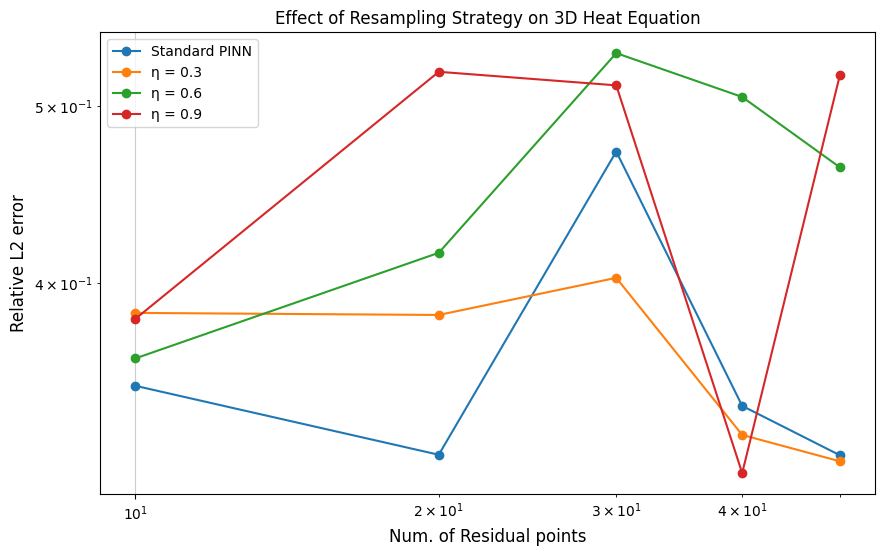

In [5]:
run_all_experiments()